## Setup

In [28]:
## PATH STUFF FIRST SO EASY TO SWITCH BETWEEN US ##

# Set working directory
# os.chdir("/Users/alexdessouky/Desktop/MIDS/w266")
os.chdir("/Users/manat/OneDrive/Documents/Tim/MIDS/266_NLP/Final Project")

# Store the paths to bert & data
# bert_path =   '/Users/alexdessouky/Desktop/MIDS/w266/bert' 
# data_path = '/Users/alexdessouky/Desktop/MIDS/w266/w266_final_project/StanceDataset'  
# bert_path =   '/Users/manat/OneDrive/Documents/Tim/MIDS/266_NLP/w266/bert' 
# data_path = '/Users/manat/OneDrive/Documents/Tim/MIDS/266_NLP/Final Project/w266_final_project/StanceDataset'  
local_bert_path = r'C:\Users\manat\OneDrive\Documents\Tim\MIDS\266_NLP\w266\bert\\' # change as needed
data_path = r'C:\Users\manat\OneDrive\Documents\Tim\MIDS\266_NLP\Final Project\w266_final_project\StanceDataset'  

# Make sure that the paths are accessible within the notebook
sys.path.insert(0, bert_path)
sys.path.insert(0, data_path)

In [14]:
# System and Storage
import time
import os
import sys
from datetime import datetime
now = datetime.now() # current date and time

# Data structures
import pandas as pd
import numpy as np

# Strings
import string
import re

# Pre-Processing
from sklearn.preprocessing import OneHotEncoder
from itertools import compress
from sklearn.utils.class_weight import compute_class_weight

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub
# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

# Outputs
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
# Load data
# Training data
twitter_train = pd.read_excel('./w266_final_project/StanceDataset/train.xlsx')

# Test data
twitter_test = pd.read_excel('./w266_final_project/StanceDataset/test.xlsx')

twitter_train_raw.shape

(2914, 5)

## Pre-Process Data  

### Labels $y$

In [118]:
# PREP LABELS FOR NN
stance_train = np.array(twitter_train['Stance'])
stance_test = np.array(twitter_test['Stance'])

# One-hot Encoder
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(stance_train.reshape(-1, 1))
label_categories = enc.categories_[0]

labels_train = enc.transform(stance_train.reshape(-1, 1)).toarray()
labels_test = enc.transform(stance_test.reshape(-1, 1)).toarray()

print(label_categories)
print(labels_train[:5])

['AGAINST' 'FAVOR' 'NONE']
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


### Tokens $x$

In [119]:
def preprocess_tweets(x):
    
    # Remove punctuation EXCEPT for hashtags (#) and handles (@)
    exclude_punc = [punc for punc in string.punctuation if punc not in ['#', '@']]
    x_nopunc = ''.join(ch for ch in x if ch not in exclude_punc)

    # lower case
    x_lower = x_nopunc.lower()
    
    # Replace digits with DIGIT
    x_digits = re.sub("\d+", "DIGIT", x_lower)
    
    return x_digits

# Clean tweests
twitter_train['tweet_clean'] = np.array(twitter_train['Tweet'].apply(lambda x: preprocess_tweets(x)))
twitter_test['tweet_clean'] = np.array(twitter_test['Tweet'].apply(lambda x: preprocess_tweets(x)))

# Example tweet
print("Raw: " + str(twitter_train['Tweet'][0]))
print("Clean: " + str(preprocess_tweets(twitter_train['Tweet'][0])))

Raw: @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot
Clean: @tedcruz and #handovertheserver she wiped clean  DIGITk deleted emails explains dereliction of dutylies re #benghazietc #tcot


In [120]:
train_x = twitter_train['tweet_clean']
test_x = twitter_test['tweet_clean']

train_x[:5]

0    @tedcruz and #handovertheserver she wiped clea...
1    hillary is our best choice if we truly want to...
2    @theview i think our country is ready for a fe...
3    i just gave an unhealthy amount of my hardearn...
4    @portiaaboulger thank you for adding me to you...
Name: tweet_clean, dtype: object

### Bert tokenizer

In [121]:
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"
bert_url

'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'

In [122]:
# Define maximal length of input 'sentences' (post tokenization).
max_length = 83

In [100]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [125]:
# Create tokens surrounded by the [CLS] and [SEP] tokens
train_tokens = train_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
test_tokens = test_x.apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])

# Mask ids (mask out the paddings)
train_mask_ids = train_tokens.apply(lambda x: len(x)*[1])
test_mask_ids = test_tokens.apply(lambda x: len(x)*[1])

train_mask_ids = train_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                      np.array(x)).tolist()
test_mask_ids = test_mask_ids.apply(lambda x: np.array(x + (max_length - len(x)) * [0]) if len(x) < max_length else 
                                    np.array(x)).tolist()

# Add padding to tokens
train_tokens = train_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)
test_tokens = test_tokens.apply(lambda x: x + (max_length - len(x)) * ['[PAD]'] if len(x) < max_length else x)

# Sequence vectors
train_sequenceids = train_tokens.apply(lambda x: np.array(max_length*[0])).tolist()
test_sequenceids = test_tokens.apply(lambda x: np.array(max_length*[0])).tolist()

# Convert tokens to sentence ids
train_sentenceids = train_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()
test_sentenceids = test_tokens.apply(lambda x: np.array(tokenizer.convert_tokens_to_ids(x))).tolist()

# Bert features
bert_train = [np.array(train_sentenceids), np.array(train_mask_ids), np.array(train_sequenceids)]
bert_test = [np.array(test_sentenceids), np.array(test_mask_ids), np.array(test_sequenceids)]

In [124]:
print(train_x[0])
print(train_tokens[0])

# NOTES: why such small tokens? e.g. benghazi has to be an important token by itself, right?

@tedcruz and #handovertheserver she wiped clean  DIGITk deleted emails explains dereliction of dutylies re #benghazietc #tcot
['[CLS]', '@', 'te', '##d', '##c', '##ru', '##z', 'and', '#', 'hand', '##over', '##the', '##serve', '##r', 'she', 'wiped', 'clean', 'D', '##IG', '##IT', '##k', 'deleted', 'emails', 'explains', 'der', '##eli', '##ction', 'of', 'duty', '##lies', 're', '#', 'ben', '##gh', '##azi', '##et', '##c', '#', 't', '##cot', '[SEP]']


In [126]:
print(train_mask_ids[0])

# NOTES: unclear

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [128]:
print(train_tokens[0])

# NOTES: every tweet same length of tokens (max_length)

['[CLS]', '@', 'te', '##d', '##c', '##ru', '##z', 'and', '#', 'hand', '##over', '##the', '##serve', '##r', 'she', 'wiped', 'clean', 'D', '##IG', '##IT', '##k', 'deleted', 'emails', 'explains', 'der', '##eli', '##ction', 'of', 'duty', '##lies', 're', '#', 'ben', '##gh', '##azi', '##et', '##c', '#', 't', '##cot', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [130]:
print(train_sequenceids[0])
print(train_sequenceids[100])
print(train_sentenceids[1])

# NOTES: what are sequence ids?

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
[ 101 4665 3113 1110 1412 1436 3026 1191 1195 5098 1328 1106 2760 1217
  170 8706 3790  108 9294 2660  102    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [132]:
print(bert_train)

[array([[  101,   137, 21359, ...,     0,     0,     0],
       [  101,  4665,  3113, ...,     0,     0,     0],
       [  101,   137,  1103, ...,     0,     0,     0],
       ...,
       [  101,  1293,  9164, ...,     0,     0,     0],
       [  101,  4463,  2266, ...,     0,     0,     0],
       [  101,   108,  9814, ...,     0,     0,     0]]), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])]


## Subset by Target

In [163]:
print(len(train_sentenceids))
print(len(train_mask_ids))
print(len(train_sequenceids))
print(labels_train.shape)

print(len(test_sentenceids))
print(len(test_mask_ids))
print(len(test_sequenceids))
print(labels_test.shape)

2914
2914
2914
(2914, 3)
1956
1956
1956
(1956, 3)


In [165]:
# Hillary
topic_list = ['hillary clinton']
matches_hillary_train = np.array(twitter_train['Target'].apply(lambda x: x.lower() in topic_list))
matches_hillary_test = np.array(twitter_test['Target'].apply(lambda x: x.lower() in topic_list))

labels_train_hillary = labels_train[matches_hillary_train,]
labels_test_hillary = labels_test[matches_hillary_test,]

train_sentenceids_hillary = list(compress(train_sentenceids, matches_hillary_train))
train_mask_ids_hillary = list(compress(train_mask_ids, matches_hillary_train))
train_sequenceids_hillary = list(compress(train_sequenceids, matches_hillary_train))
test_sentenceids_hillary = list(compress(test_sentenceids, matches_hillary_test))
test_mask_ids_hillary = list(compress(test_mask_ids, matches_hillary_test))
test_sequenceids_hillary = list(compress(test_sequenceids, matches_hillary_test))

bert_train_hillary = [np.array(train_sentenceids_hillary), 
                      np.array(train_mask_ids_hillary), 
                      np.array(train_sequenceids_hillary)]
bert_test_hillary = [np.array(test_sentenceids_hillary), 
                     np.array(test_mask_ids_hillary), 
                     np.array(test_sequenceids_hillary)]

In [166]:
print(len(train_sentenceids_hillary))
print(len(train_mask_ids_hillary))
print(len(train_sequenceids_hillary))
print(labels_train_hillary.shape)

print(len(test_sentenceids_hillary))
print(len(test_mask_ids_hillary))
print(len(test_sequenceids_hillary))
print(labels_test_hillary.shape)

689
689
689
(689, 3)
295
295
295
(295, 3)


## Custom layer to create Bert

In [133]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_url,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [134]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## Define Model

In [136]:
# NOTES: 
    # why have max_input_length as a parameter when we use max_length?

def bert_model(max_input_length, train_layers, optimizer = tf.keras.optimizers.Adam(learning_rate=1)):
    
    in_id = tf.keras.layers.Input(shape=(max_input_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_input_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_input_length,), name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_sequence = BertLayer(n_fine_tune_layers = train_layers)(bert_inputs)
    
    #dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
    
    dropout = tf.keras.layers.Dropout(rate=0.3)(bert_sequence)
    
    pred = tf.keras.layers.Dense(3, activation='softmax', name='classification')(dropout)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['categorical_accuracy'])
    
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [170]:
compute_class = compute_class_weight('balanced', np.unique(stance_train), stance_train)
weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}
weights

{0: 0.6962962962962963, 1: 1.289951305887561, 2: 1.268059181897302}

In [171]:
#Start session

sess = tf.Session()

model = bert_model(max_input_length = max_length, # + 1 
                   train_layers = 12, 
                   optimizer = 'adam')

# Instantiate variables
initialize_vars(sess)

model.fit(
    x = bert_train_hillary, 
    y = labels_train_hillary,
    validation_split = 0.2,
    shuffle = True,
    epochs = 30,
    verbose = 1,
    batch_size=32,
    class_weight = weights
)    

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 83)]         0                                            
__________________________________________________________________________________________________
bert_layer_7 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [173]:
test_hillary = model.predict(bert_test_hillary)

In [174]:
np.argmax(test_hillary, axis = 1)

array([0, 2, 2, 0, 2, 1, 0, 2, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0,
       0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 1, 1, 0, 0, 0, 1,
       2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0,
       2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 0, 2, 2, 0, 2, 0, 0,
       0, 2, 2, 0, 1, 2, 0, 0, 2], dtype=int64)

In [179]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    
def metrics(true_labels_in, test_probs):
    
    #find predicted labels
    test_predicts = np.argmax(test_probs, axis = 1)
    true_labels = np.argmax(true_labels_in, axis = 1)
    
    #calculate f1 score
    f1 = f1_score(true_labels, test_predicts, average = 'macro')
    
    print("F1 macro score:", f1)
    
    print(classification_report(y_true = true_labels, 
                                        y_pred = test_predicts,
                                        target_names = ['Against', 'None', 'Favor']))
    
    confuse = confusion_matrix(y_true = true_labels, y_pred = test_predicts)
    
    plt.figure(figsize=(15, 5))
    confusion_plot(confuse, ['Against', 'None', 'Favor'])
    plt.show()

F1 macro score: 0.6099603824497372
              precision    recall  f1-score   support

     Against       0.74      0.74      0.74       172
        None       0.54      0.31      0.39        45
       Favor       0.63      0.78      0.70        78

    accuracy                           0.68       295
   macro avg       0.64      0.61      0.61       295
weighted avg       0.68      0.68      0.67       295



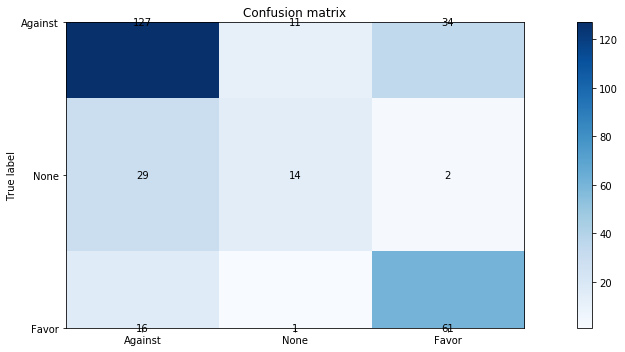

In [180]:
metrics(true_labels_in = labels_test_hillary, 
        test_probs = test_hillary)